In [1]:
!git clone https://github.com/ezaaputra/indonlu.git

fatal: destination path 'indonlu' already exists and is not an empty directory.


In [2]:
!pip install emoji
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [4]:
#NLP
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import emoji

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [6]:
#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

In [7]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

In [8]:
torch.cuda.get_device_name(0)

'Tesla T4'

Data Preparation

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data = pd.read_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/tweet.csv')

In [11]:
data

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...
1810,1810,netral,Negarawan sejati sll bangga dan mengedepankan ...
1811,1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...
1813,1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...


In [12]:
df = pd.DataFrame(data)

In [13]:
df

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...
1810,1810,netral,Negarawan sejati sll bangga dan mengedepankan ...
1811,1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...
1813,1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...


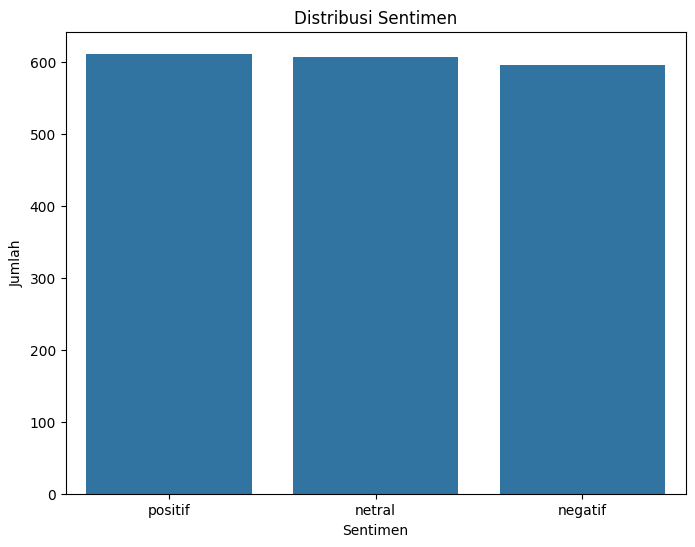

In [14]:
sentiment_counts = df['sentimen'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

Data Cleaning

In [15]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','<','>',
             '"','/','\'','#','-','@','a','b','c','d','e','f','g','h','i',
             'j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
             'y','z','A','B','C','D','E','F','G','H','I','J','K','L','M',
             'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yan berulang
def repeatcharClean(text):
  for i in range (len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

Case Folding

In [16]:
def clean_review(text):
  # ubah text jadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  # Escape the parentheses within the character set
  text = re.sub(r"[xX;:]'?[dDpPvVoO3\)\(]+", ' ', text) # Updated regex
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9].[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus username
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ', text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

Data Preprocessing

In [17]:
def preprocess_v1(df):
  df_pp = df.copy()
  # Apply clean_review function to the 'tweet' column instead of 'Subject'
  df_pp.tweet = df_pp.tweet.map(clean_review)

  # delete empty row
  df_pp.tweet.replace('', np.nan, inplace=True)
  df_pp.tweet.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['tweet'], inplace=True)
  return df_pp

# hasil preprocessing
df_v1 = preprocess_v1(df)
df_v1

<ipython-input-17-6b68a511ba23>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.tweet.replace('', np.nan, inplace=True)
<ipython-input-17-6b68a511ba23>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

,Unnamed: 0,sentimen,tweet
0,0,negatif,kata indonesia tidak dihargai bangsa asing! be...
1,1,netral,"batuan langka, tasbih jokowi hadiah dari habib..."
2,2,netral,"di era jokowi, ekonomi indonesia semakin baik...."
3,3,positif,"bagi sumatera selatan, asian games berdampak p..."
4,4,negatif,negara kita ngutang buat bngun infrastruktur y...
...,...,...,...
1810,1810,netral,negarawan sejati sll bangga dan mengedepankan ...
1811,1811,netral,. hrs ceramah di damai indonesiaku . perekono...
1812,1812,netral,mari bangun bangsa dgn mendukung perekonomian ...
1813,1813,netral,bantu majukan perekonomian bangsa bersama pak ...


Split Dataset
1. Data Training 70%
2. Data Visualisasi 20%
3. Data Test (Uji Coba) 10%

In [18]:
#train val split
train_set, val_set = train_test_split(df_v1, test_size=0.3, random_state=1, stratify=df_v1['sentimen'])
val_set, test_set = train_test_split(val_set, test_size=0.33, random_state=1, stratify=val_set['sentimen'])

In [19]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (1270, 3)
Val shape: (365, 3)
Test shape: (180, 3)


In [20]:
# export to csv
# Select only the 'tweet' and 'sentimen' columns before saving
train_set[['tweet', 'sentimen']].to_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/train.csv', sep='\t', header=None, index=False)
val_set[['tweet', 'sentimen']].to_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/val.csv', sep='\t', header=None, index=False)
test_set[['tweet', 'sentimen']].to_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/test.csv', sep='\t', header=None, index=False)

Training Dataset:
Fungsi set_seed digunakan untuk menentukan seed /random number generator agar data/keacakan sesuatu bisa diatur sehingga antara percobaan pertama dan seterusnya menggunakan data acak yang sama.

In [21]:
# common functions

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
  if trainable:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def metrics_to_string(metric_dict):
  string_list = []
  for key, value in metric_dict.items():
    string_list.append('{}:{:.2f}'.format(key, value))
  return ' '.join(string_list)

# set random seed
set_seed(27)
print(set_seed)

<function set_seed at 0x7e5776f18180>


1. Tokenisasi Dataset
2. Instalasi pre-trained Model IndoBERT

In [22]:
# Load Tokenizer & Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Struktur model
print(model)

# Jumlah parameter
print(count_param(model))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Data loading

In [23]:
# Re-load the original dataset if needed
data = pd.read_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/tweet.csv')
df = pd.DataFrame(data)
df_v1 = preprocess_v1(df) # Apply preprocessing again if starting from original data

<ipython-input-17-6b68a511ba23>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.tweet.replace('', np.nan, inplace=True)
<ipython-input-17-6b68a511ba23>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [24]:
# Assuming the error 'positif' implies the class expects 'positive'
# Check the unique values in your sentiment column
print("Unique sentiment values before mapping:", df_v1['sentimen'].unique())

Unique sentiment values before mapping: ['negatif' 'netral' 'positif']


In [25]:
# You might need to instantiate a dummy dataset object to access LABEL2INDEX
# This is a common way to inspect class attributes when not directly imported
try:
    dummy_dataset = DocumentSentimentDataset('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/train.csv', tokenizer, lowercase=True)
    print("DocumentSentimentDataset LABEL2INDEX:", dummy_dataset.LABEL2INDEX)
except Exception as e:
    print("Could not instantiate dummy dataset to check LABEL2INDEX:", e)
    print("Assuming the expected labels are 'positive', 'negative', 'neutral'.")
    # If you cannot instantiate, you might need to look at the indonlu library code
    # Or, based on common sentiment analysis datasets, assume the English labels.

Could not instantiate dummy dataset to check LABEL2INDEX: 'positif'
Assuming the expected labels are 'positive', 'negative', 'neutral'.


In [26]:
# Based on the Key Error 'positif', it's highly likely the class expects 'positive'.
# Map your current labels to the expected labels
sentiment_mapping = {
    'positif': 'positive',
    'negatif': 'negative',
    'netral': 'neutral' # Assuming 'netral' needs to be mapped as well
}

In [27]:
df_v1['sentimen'] = df_v1['sentimen'].map(sentiment_mapping)

# Check the unique values after mapping
print("Unique sentiment values after mapping:", df_v1['sentimen'].unique())

Unique sentiment values after mapping: ['negative' 'neutral' 'positive']


In [28]:
# Split dataset again with the corrected labels
train_set, val_set = train_test_split(df_v1, test_size=0.3, random_state=1, stratify=df_v1['sentimen'])
val_set, test_set = train_test_split(val_set, test_size=0.33, random_state=1, stratify=val_set['sentimen'])

In [29]:
# Export to csv with the corrected labels
train_set[['tweet', 'sentimen']].to_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/train.csv', sep='\t', header=None, index=False)
val_set[['tweet', 'sentimen']].to_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/val.csv', sep='\t', header=None, index=False)
test_set[['tweet', 'sentimen']].to_csv('/content/drive/MyDrive/Sentimen Analisis/Al_NLP/test.csv', sep='\t', header=None, index=False)

In [30]:
# Now, try running the dataset loading code again
from indonlu.utils.data_utils import DocumentSentimentDataset # Import if not already imported
train_dataset_path = '/content/drive/MyDrive/Sentimen Analisis/Al_NLP/train.csv'
valid_dataset_path = '/content/drive/MyDrive/Sentimen Analisis/Al_NLP/val.csv'
test_dataset_path = '/content/drive/MyDrive/Sentimen Analisis/Al_NLP/test.csv'

In [31]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

In [32]:
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [33]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) # word to index
print(i2w) # index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


Contoh dataset yang sudah ditokenisasi

In [34]:
tweet = df_v1.tweet.values
tokenized_texts = tokenizer.tokenize(tweet[74])

input_ids = []

for sent in tweet:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", tweet[74])
print("Tokenized: ", tokenized_texts)
print("Input IDs: ", input_ids[74])

Original:  demikian pak walau pendidikannya tentara .. tapi ayahnya seorang ekonom legendaris di indonesia .. ya kali deh gak ngerti makro dan mikro .. makro dan mikro pelajaran semester di fakultas ekonomi .. cmiiw ketauan .. jae baru belajar ekonomi .. kacaw..
Tokenized:  ['demikian', 'pak', 'walau', 'pendidikannya', 'tentara', '.', '.', 'tapi', 'ayahnya', 'seorang', 'ekonom', 'legendaris', 'di', 'indonesia', '.', '.', 'ya', 'kali', 'deh', 'gak', 'ngerti', 'makro', 'dan', 'mikro', '.', '.', 'makro', 'dan', 'mikro', 'pelajaran', 'semester', 'di', 'fakultas', 'ekonomi', '.', '.', 'cm', '##ii', '##w', 'keta', '##uan', '.', '.', 'jae', 'baru', 'belajar', 'ekonomi', '.', '.', 'kaca', '##w', '.', '.']
Input IDs:  [2, 1143, 556, 1766, 17381, 5085, 30470, 30470, 469, 5854, 596, 6406, 16949, 26, 300, 30470, 30470, 286, 633, 2983, 1489, 12056, 13135, 41, 6782, 30470, 30470, 13135, 41, 6782, 2269, 4890, 26, 4344, 1447, 30470, 30470, 2825, 4264, 30374, 12726, 227, 30470, 30470, 18216, 440, 929, 

Fine Tuning & Evaluation Dataset

In [35]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [36]:
# Train
n_epochs = 4
history = defaultdict(list)
for epoch in range(n_epochs):
  model.train()
  torch.set_grad_enabled(True)

  total_train_loss = 0
  list_hyp, list_label = [], [] # These accumulate predictions and labels for the current epoch

  train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
  for i, batch_data in enumerate(train_pbar):
    # Forward model
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    # Update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tr_loss = loss.item()
    total_train_loss = total_train_loss + tr_loss

    # Hitung skor train metrics
    list_hyp += batch_hyp
    list_label += batch_label

    train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
                                                                               total_train_loss/(i+1), get_lr(optimizer)))
  # Use the accumulated list_hyp for training metrics, not a variable that doesn't exist
  metrics = document_sentiment_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
                                                            total_train_loss/(i+1),
                                                            metrics_to_string(metrics),
                                                            get_lr(optimizer)))

  # save train acc for learning curve
  history['train_acc'].append(metrics['ACC'])

  # Evaluate di validation set
  model.eval()
  torch.set_grad_enabled(False)

  total_loss, total_correct, total_labels = 0, 0, 0
  list_hyp, list_label = [], [] # These accumulate predictions and labels for the current epoch for validation

  pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
  for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    # Hitung total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # Hitung skor evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)

    pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

  metrics = document_sentiment_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
                                                  total_loss/(i+1),
                                                  metrics_to_string(metrics)))

  # save validation acc for learning curve
  history['val_acc'].append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:1.0059 LR:0.00000300: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]


(Epoch 1) TRAIN LOSS:1.0059 ACC:0.49 F1:0.49 REC:0.49 PRE:0.49 LR:0.00000300


  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.9107 ACC:0.62 F1:0.62 REC:0.62 PRE:0.62: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s]


(Epoch 1) VALID LOSS:0.9107 ACC:0.62 F1:0.62 REC:0.62 PRE:0.62


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.8821 LR:0.00000300: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


(Epoch 2) TRAIN LOSS:0.8821 ACC:0.63 F1:0.63 REC:0.63 PRE:0.64 LR:0.00000300


  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.8247 ACC:0.65 F1:0.65 REC:0.65 PRE:0.65: 100%|██████████| 12/12 [00:02<00:00,  4.85it/s]


(Epoch 2) VALID LOSS:0.8247 ACC:0.65 F1:0.65 REC:0.65 PRE:0.65


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.8018 LR:0.00000300: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


(Epoch 3) TRAIN LOSS:0.8018 ACC:0.68 F1:0.68 REC:0.68 PRE:0.68 LR:0.00000300


  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.7636 ACC:0.66 F1:0.66 REC:0.66 PRE:0.67: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


(Epoch 3) VALID LOSS:0.7636 ACC:0.66 F1:0.66 REC:0.66 PRE:0.67


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.7231 LR:0.00000300: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


(Epoch 4) TRAIN LOSS:0.7231 ACC:0.71 F1:0.71 REC:0.71 PRE:0.71 LR:0.00000300


  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.7261 ACC:0.69 F1:0.69 REC:0.69 PRE:0.70: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]

(Epoch 4) VALID LOSS:0.7261 ACC:0.69 F1:0.69 REC:0.69 PRE:0.70


Visualisasi Hasil Training & Evaluasi

(0.0, 1.0)

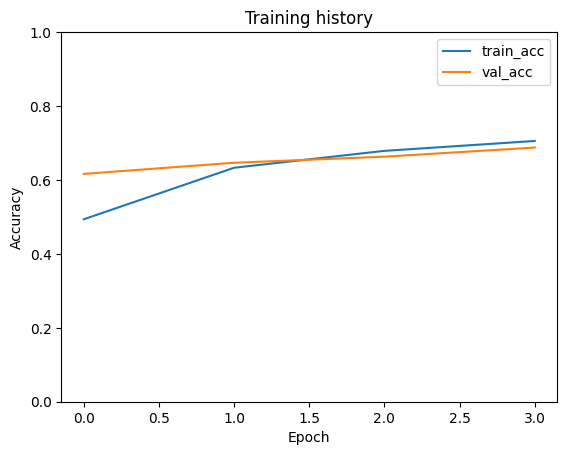

In [37]:
# chat training model
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

Testing Model

In [39]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
  _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
  pred += batch_hyp

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


In [42]:
# Simpan prediksi data set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['tweet', 'sentimen'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

print(test_df)

                                                 tweet  sentimen      pred
0    yg tilil capres lu zer wong presiden ngomongny...  negative  negative
1          ayo segera usut kalian di gaji oleh rakyat.   neutral  positive
2    hm, ketika paslon bahas ekonomi makro secara g...  positive  positive
3    prabowosalahkansby semakin mantap pilih ps bil...  positive  positive
4    jokowi pinter ngeles. sudah gagal bangun perek...  negative  negative
..                                                 ...       ...       ...
175  pa autokritik, bapaknya saja lama jadi mentri ...  negative  negative
176  calon presiden capres nomor urut joko widodo m...   neutral   neutral
177  jokowi tegaskan pancasila, nkri, bhinneka tung...   neutral   neutral
178  kekayaan pak jokowi salah satunya asset tanah ...   neutral  negative
179  yg ada malah coblos prabowo sandi dapat pahala...  positive  positive

[180 rows x 3 columns]


In [45]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

# Capture predictions for the test set
test_pred_list = []
pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
  _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
  test_pred_list += batch_hyp # Accumulate predictions for the test set

# Capture predictions for the validation set during evaluation
# This part was previously missing or not explicitly stored for later use
val_pred_list = []
total_loss, total_correct, total_labels = 0, 0, 0 # Re-initialize for clarity, though not strictly necessary for just capturing preds
pbar_val = tqdm(valid_loader, leave=True, total=len(valid_loader), desc="Capturing Validation Predictions")
for i, batch_data in enumerate(pbar_val):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    val_pred_list += batch_hyp # Accumulate predictions for the validation set

# Simpan prediksi data set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['tweet', 'sentimen'])
# Add the collected test predictions to the test_df
test_df['pred'] = test_pred_list
test_df.head()
test_df.to_csv('test result.csv', index=False)

print(test_df)

# Load the validation dataset and add the captured validation predictions
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['tweet', 'sentimen'])
# Add the collected validation predictions to the val_df
val_df['pred'] = val_pred_list

# Now you can access val_df.pred and test_df.pred
val_real = val_df.sentimen
val_pred = val_df.pred

test_real = test_df.sentimen
test_pred = test_df.pred

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Capturing Validation Predictions: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]

                                                 tweet  sentimen      pred
0    yg tilil capres lu zer wong presiden ngomongny...  negative  negative
1          ayo segera usut kalian di gaji oleh rakyat.   neutral  positive
2    hm, ketika paslon bahas ekonomi makro secara g...  positive  positive
3    prabowosalahkansby semakin mantap pilih ps bil...  positive  positive
4    jokowi pinter ngeles. sudah gagal bangun perek...  negative  negative
..                                                 ...       ...       ...
175  pa autokritik, bapaknya saja lama jadi mentri ...  negative  negative
176  calon presiden capres nomor urut joko widodo m...   neutral   neutral
177  jokowi tegaskan pancasila, nkri, bhinneka tung...   neutral   neutral
178  kekayaan pak jokowi salah satunya asset tanah ...   neutral  negative
179  yg ada malah coblos prabowo sandi dapat pahala...  positive  positive

[180 rows x 3 columns]


Classification Report Confusion Matrix

Validation Dataset (Fase Training & Evaluation Model)

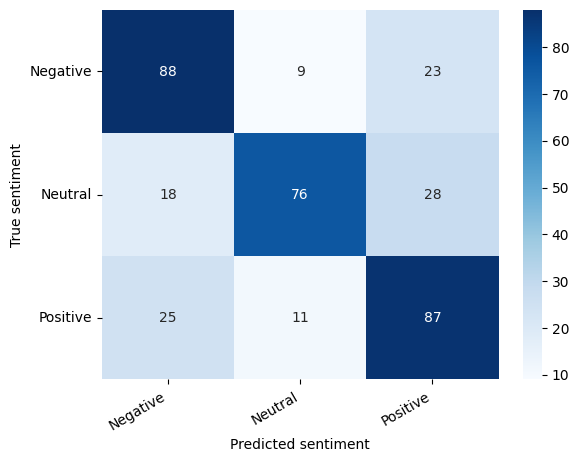

In [46]:
#confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index =['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
show_confusion_matrix(df_cm)

In [47]:
print(classification_report(val_real, val_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.67      0.73      0.70       120
     Neutral       0.79      0.62      0.70       122
    Positive       0.63      0.71      0.67       123

    accuracy                           0.69       365
   macro avg       0.70      0.69      0.69       365
weighted avg       0.70      0.69      0.69       365



Test Dataset

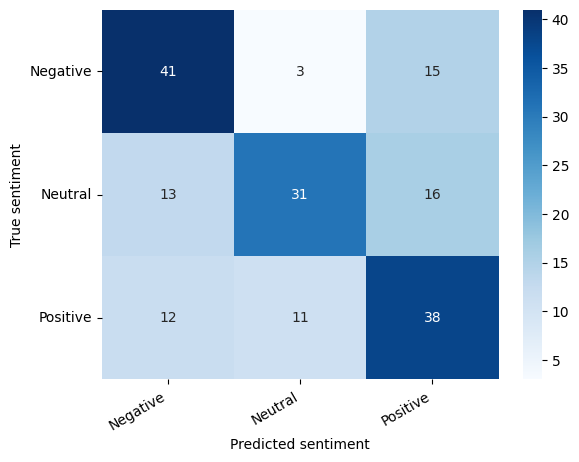

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index =['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
show_confusion_matrix(df_cm)

In [49]:
print(classification_report(test_real, test_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.62      0.69      0.66        59
     Neutral       0.69      0.52      0.59        60
    Positive       0.55      0.62      0.58        61

    accuracy                           0.61       180
   macro avg       0.62      0.61      0.61       180
weighted avg       0.62      0.61      0.61       180

